In [22]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
import networkx as nx # for visualizing graphs

import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

### Simple example:

In [2]:
# Define two (bidirectional) edges: between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], 
                           [1, 0, 2, 1]], dtype=torch.long)

# Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

# Put it all together
data = Data(x=x, edge_index=edge_index)

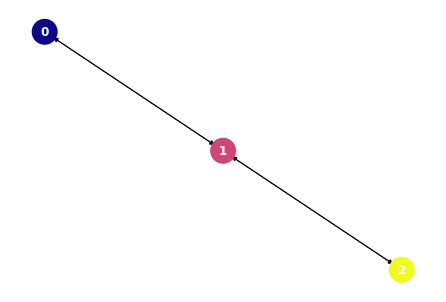

In [3]:
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [4]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 1 node feature(s) each.
Graph has 3 nodes and 4 edges.
Is the graph undirected?: True


# Load the ENZYMES dataset & visualize it

In [13]:
# load the dataset
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), 
                                                                             enzymes.num_classes, 
                                                                             enzymes.num_node_features))
print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

# now turn it into graphs
graphs = GraphDataset.pyg_to_graphs(enzymes) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))

Dataset has 600 entries, with 6 classes and 3 node features.
First entry has 37 nodes and 168 edges.
Is the graph undirected?: True
Dataset has 6 classes
Dataset has 3 node features


In [16]:
enzymes[500].y # overall class of this protein

tensor([3])

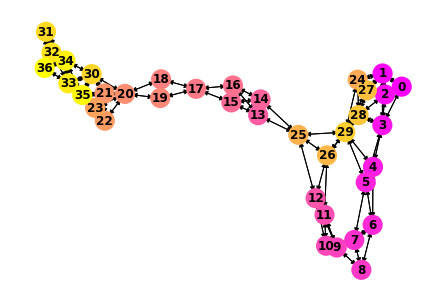

In [17]:
plt.figure() 
graph = enzymes[0]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

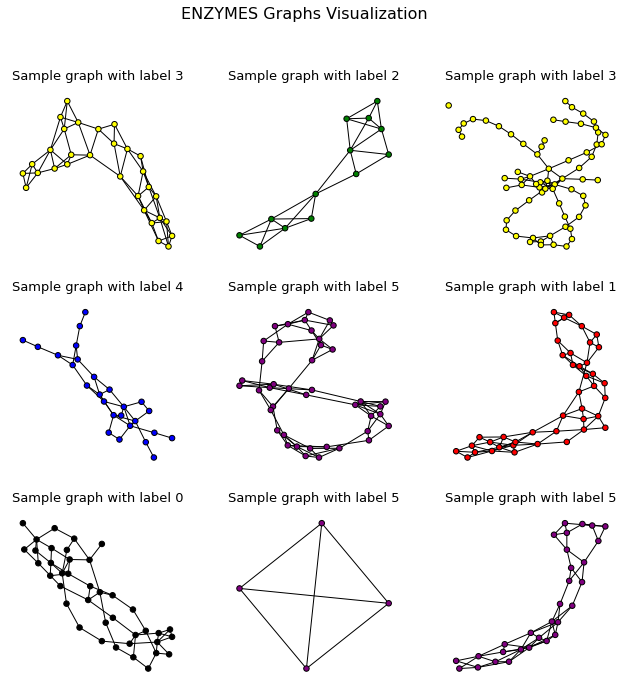

In [18]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Define a basic GNN for graph classification:

In [19]:
class GIN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Define train & test functions:

In [20]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

Train!

In [23]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 256,
    "epochs" : 100,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.1750, Validation: 0.1667. Test: 0.3167, Loss: 7.1292
Epoch 2: Train: 0.2375, Validation: 0.2333. Test: 0.3167, Loss: 3.4932
Epoch 3: Train: 0.2667, Validation: 0.1500. Test: 0.2333, Loss: 2.5420
Epoch 4: Train: 0.2917, Validation: 0.1500. Test: 0.1667, Loss: 1.9988
Epoch 5: Train: 0.3146, Validation: 0.1667. Test: 0.2833, Loss: 1.9493
Epoch 6: Train: 0.3146, Validation: 0.1667. Test: 0.3167, Loss: 1.7814
Epoch 7: Train: 0.3583, Validation: 0.3167. Test: 0.3833, Loss: 1.8352
Epoch 8: Train: 0.3958, Validation: 0.3333. Test: 0.3500, Loss: 1.7212
Epoch 9: Train: 0.4417, Validation: 0.3333. Test: 0.2667, Loss: 1.6051
Epoch 10: Train: 0.4229, Validation: 0.3000. Test: 0.3333, Loss: 1.5727
Epoch 11: Train: 0.4250, Validation: 0.3333. Test: 0.3833, Loss: 1.5482
Epoch 12: Train: 0.4458, Validation: 0.4000. Test: 0.2833, Loss: 1.5313
Epoch 13: Train: 0.4167, Validation: 0.3167. Test: 0.3833, Loss: 1.6148
Epoch 14: Train: 0.4083, Validation: 0.4000. Test: 0.3333, Loss: 1.6593
E

In [54]:
def test(loader, model, device='cuda'): # with printouts
    model.eval()
    correct = 0
    num_graphs = 0
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            print("Predicted labels:", pred)
            label = batch.graph_label
            print("True labels:", label)
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
        batch_num += 1
        print("Total graphs in batch:", batch.num_graphs)
        print("Number correctly predicted:", pred.eq(label).sum().item())
        print("Accuracy = {:.2f}%".format(100*pred.eq(label).sum().item()/batch.num_graphs))
    print("\nOut of all {} test graphs, {} predictions were correct.".format(num_graphs, correct))
    print("Total accuracy = {:.2f}%".format(100*correct/num_graphs))       
    return correct / num_graphs

In [55]:
test_acc = test(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([4, 2, 2, 0, 1, 2, 2, 3, 2, 4, 3, 2, 4, 3, 5, 1, 4, 4, 1, 1, 1, 1, 4, 3,
        2, 3, 4, 4, 5, 5, 2, 2])
True labels: tensor([4, 2, 2, 5, 2, 0, 2, 4, 2, 1, 1, 2, 1, 5, 4, 1, 2, 0, 1, 3, 4, 5, 4, 3,
        2, 0, 0, 2, 5, 0, 2, 2])
Total graphs in batch: 32
Number correctly predicted: 14
Accuracy = 43.75%
====== BATCH 1 ======
Predicted labels: tensor([2, 2, 5, 2, 1, 3, 0, 5, 3, 0, 1, 1, 1, 1, 3, 0, 2, 4, 1, 1, 2, 2, 2, 2,
        1, 2, 1, 3])
True labels: tensor([0, 2, 4, 2, 4, 1, 0, 1, 3, 2, 5, 4, 0, 1, 3, 5, 2, 0, 0, 5, 2, 2, 2, 1,
        0, 4, 1, 3])
Total graphs in batch: 28
Number correctly predicted: 12
Accuracy = 42.86%

Out of all 60 test graphs, 26 predictions were correct.
Total accuracy = 43.33%
